### Separação de Dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')


In [2]:
colunas = ["IN_TREINEIRO", 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', "TP_ESCOLA", "SG_UF_ESC", "TP_LOCALIZACAO_ESC", 'Q001', 'Q002', 'Q005', 'Q006', 'Q007', 
                           "Q010", "Q011", "Q012", "Q019", 'Q021', 'Q022', 'Q024', 'Q025'  ]

colunas_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']

colunas_socioEconomicas = ["TP_ESCOLA", "SG_UF_ESC", "TP_LOCALIZACAO_ESC", 'Q001', 'Q002', 'Q005', 'Q006', 'Q007', 
                           "Q010", "Q011", "Q012", "Q019", 'Q021', 'Q022', 'Q024', 'Q025']


dados =  pd.read_csv(
        'MICRODADOS_ENEM_2023.csv',
        encoding = 'latin1',
        usecols = colunas,
        sep = ';'
    )



# dados_notas =  pd.read_csv(
 #       'MICRODADOS_ENEM_2023.csv',
  #      encoding = 'latin1',
   #     usecols = colunas_notas,
    #    sep = ';'
#    ) # .dropna()


#dados_socioEconomicas =  pd.read_csv(
 #       'MICRODADOS_ENEM_2023.csv',
  #      encoding = 'latin1',
   #     usecols = colunas_socioEconomicas,
    #    sep = ';'
    #) # .dropna()

In [3]:
dados = dados.loc[(dados["NU_NOTA_CN"] != 0) 
                                              & (dados["NU_NOTA_CH"] != 0) 
                                               & (dados["NU_NOTA_LC"] != 0) 
                                                  & (dados["NU_NOTA_MT"] != 0) 
                                                     & (dados["NU_NOTA_REDACAO"] != 0) ].copy()

In [4]:
dados["Media_Notas_Objetivas"] = dados[['NU_NOTA_CN', 'NU_NOTA_CH',
                                                             'NU_NOTA_LC', 'NU_NOTA_MT']].mean(axis=1)

In [5]:
# dados_mediaObjetiva = dados_notas["Media_Notas_Objetivas"].copy()

In [6]:
dados = dados.loc[dados["IN_TREINEIRO"]==0].copy()

# dados_socioEconomicas = dados_socioEconomicas.loc[dados_socioEconomicas["IN_TREINEIRO"]==0].copy()


In [7]:
dados = dados.loc[ (dados["TP_ESCOLA"]==2) | (dados["TP_ESCOLA"]==3) ].copy()

In [8]:
dados.drop('IN_TREINEIRO', axis=1, inplace=True)

In [9]:
dados.isnull().sum()

TP_ESCOLA                     0
SG_UF_ESC                422846
TP_LOCALIZACAO_ESC       422846
NU_NOTA_CN               334647
NU_NOTA_CH               301446
NU_NOTA_LC               301446
NU_NOTA_MT               334647
NU_NOTA_REDACAO          301446
Q001                          0
Q002                          0
Q005                          0
Q006                          0
Q007                          0
Q010                          0
Q011                          0
Q012                          0
Q019                          0
Q021                          0
Q022                          0
Q024                          0
Q025                          0
Media_Notas_Objetivas    297261
dtype: int64

In [10]:
dados.dropna(inplace=True)

In [11]:
dados

,TP_ESCOLA,SG_UF_ESC,TP_LOCALIZACAO_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,...,Q007,Q010,Q011,Q012,Q019,Q021,Q022,Q024,Q025,Media_Notas_Objetivas
3,2,CE,1.0,459.0,508.5,507.2,466.7,880.0,D,D,...,A,A,A,B,B,A,D,A,B,485.350
4,2,CE,1.0,402.5,379.2,446.9,338.3,560.0,B,B,...,A,A,A,B,B,A,B,A,A,391.725
11,2,PR,1.0,608.2,667.6,607.9,691.9,780.0,D,E,...,A,B,A,B,B,A,B,B,B,643.900
16,2,PA,1.0,515.7,553.1,544.4,437.0,880.0,E,E,...,A,A,A,B,B,A,D,A,B,512.550
41,2,SP,1.0,523.8,576.3,596.5,628.1,600.0,C,C,...,A,A,A,B,B,A,B,A,B,581.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933919,2,RS,1.0,557.3,546.2,532.3,539.4,600.0,B,E,...,A,B,B,B,B,A,D,A,B,543.800
3933921,2,RS,1.0,585.1,437.6,601.0,554.7,320.0,E,H,...,A,C,A,B,E,B,E,B,B,544.600
3933940,2,RS,1.0,600.7,611.2,661.6,666.2,760.0,E,F,...,A,B,A,B,E,A,E,D,B,634.925
3933944,3,RS,1.0,444.0,511.4,514.8,444.9,600.0,C,E,...,A,C,A,B,D,B,E,B,B,478.775


In [12]:
dados["NU_NOTA_CH"].describe()

count    689251.000000
mean        531.443569
std          83.089105
min         293.500000
25%         478.000000
50%         538.400000
75%         590.800000
max         823.000000
Name: NU_NOTA_CH, dtype: float64

In [13]:
dados_features = dados[colunas_socioEconomicas]

In [14]:
dados_NotaRedacao = dados["NU_NOTA_REDACAO"]
dados_NotaMediaObjetiva = dados["Media_Notas_Objetivas"]

### Tratando varaiveis categóricas 

In [15]:
from sklearn.preprocessing import OrdinalEncoder
ordinalEncoder = OrdinalEncoder()

In [16]:
# colunas_socioEconomicas = ["TP_ESCOLA", "SG_UF_ESC", "TP_LOCALIZACAO_ESC", 'Q001', 'Q002', 'Q005', 'Q006', 'Q007', 
#                           "Q010", "Q011", "Q012", "Q019", 'Q021', 'Q022', 'Q024', 'Q025']

variaveis_ordenadas = ['Q001', 'Q002', 'Q005', 'Q006', 'Q007', "Q010", "Q011", "Q012", "Q019", 'Q021', 'Q022', 'Q024', 'Q025']

variaves_nao_ordenadas = [ "TP_ESCOLA", "SG_UF_ESC", "TP_LOCALIZACAO_ESC" ]

dados_features[variaveis_ordenadas] = ordinalEncoder.fit_transform(dados_features[variaveis_ordenadas])



In [17]:
dados_features

,TP_ESCOLA,SG_UF_ESC,TP_LOCALIZACAO_ESC,Q001,Q002,Q005,Q006,Q007,Q010,Q011,Q012,Q019,Q021,Q022,Q024,Q025
3,2,CE,1.0,3.0,3.0,4.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0
4,2,CE,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
11,2,PR,1.0,3.0,4.0,4.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
16,2,PA,1.0,4.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0
41,2,SP,1.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933919,2,RS,1.0,1.0,4.0,3.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0
3933921,2,RS,1.0,4.0,7.0,2.0,7.0,0.0,2.0,0.0,1.0,4.0,1.0,4.0,1.0,1.0
3933940,2,RS,1.0,4.0,5.0,2.0,6.0,0.0,1.0,0.0,1.0,4.0,0.0,4.0,3.0,1.0
3933944,3,RS,1.0,2.0,4.0,3.0,10.0,0.0,2.0,0.0,1.0,3.0,1.0,4.0,1.0,1.0


In [18]:
onehot_enc_features = [ "TP_ESCOLA", "SG_UF_ESC", "TP_LOCALIZACAO_ESC" ]

dados_features = pd.get_dummies(dados_features, prefix=onehot_enc_features, columns=onehot_enc_features, drop_first=True)

dados_features

,Q001,Q002,Q005,Q006,Q007,Q010,Q011,Q012,Q019,Q021,...,SG_UF_ESC_RJ,SG_UF_ESC_RN,SG_UF_ESC_RO,SG_UF_ESC_RR,SG_UF_ESC_RS,SG_UF_ESC_SC,SG_UF_ESC_SE,SG_UF_ESC_SP,SG_UF_ESC_TO,TP_LOCALIZACAO_ESC_2.0
3,3.0,3.0,4.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,1.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
11,3.0,4.0,4.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
16,4.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
41,2.0,2.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933919,1.0,4.0,3.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3933921,4.0,7.0,2.0,7.0,0.0,2.0,0.0,1.0,4.0,1.0,...,False,False,False,False,True,False,False,False,False,False
3933940,4.0,5.0,2.0,6.0,0.0,1.0,0.0,1.0,4.0,0.0,...,False,False,False,False,True,False,False,False,False,False
3933944,2.0,4.0,3.0,10.0,0.0,2.0,0.0,1.0,3.0,1.0,...,False,False,False,False,True,False,False,False,False,False


In [19]:
dados_features = dados_features.astype(int)

In [20]:
dados_features

,Q001,Q002,Q005,Q006,Q007,Q010,Q011,Q012,Q019,Q021,...,SG_UF_ESC_RJ,SG_UF_ESC_RN,SG_UF_ESC_RO,SG_UF_ESC_RR,SG_UF_ESC_RS,SG_UF_ESC_SC,SG_UF_ESC_SE,SG_UF_ESC_SP,SG_UF_ESC_TO,TP_LOCALIZACAO_ESC_2.0
3,3,3,4,2,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,3,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11,3,4,4,3,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
16,4,4,3,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
41,2,2,1,3,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933919,1,4,3,2,0,1,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3933921,4,7,2,7,0,2,0,1,4,1,...,0,0,0,0,1,0,0,0,0,0
3933940,4,5,2,6,0,1,0,1,4,0,...,0,0,0,0,1,0,0,0,0,0
3933944,2,4,3,10,0,2,0,1,3,1,...,0,0,0,0,1,0,0,0,0,0


In [32]:
dados_features.columns

Index(['Q001', 'Q002', 'Q005', 'Q006', 'Q007', 'Q010', 'Q011', 'Q012', 'Q019',
       'Q021', 'Q022', 'Q024', 'Q025', 'TP_ESCOLA_3', 'SG_UF_ESC_AL',
       'SG_UF_ESC_AM', 'SG_UF_ESC_AP', 'SG_UF_ESC_BA', 'SG_UF_ESC_CE',
       'SG_UF_ESC_DF', 'SG_UF_ESC_ES', 'SG_UF_ESC_GO', 'SG_UF_ESC_MA',
       'SG_UF_ESC_MG', 'SG_UF_ESC_MS', 'SG_UF_ESC_MT', 'SG_UF_ESC_PA',
       'SG_UF_ESC_PB', 'SG_UF_ESC_PE', 'SG_UF_ESC_PI', 'SG_UF_ESC_PR',
       'SG_UF_ESC_RJ', 'SG_UF_ESC_RN', 'SG_UF_ESC_RO', 'SG_UF_ESC_RR',
       'SG_UF_ESC_RS', 'SG_UF_ESC_SC', 'SG_UF_ESC_SE', 'SG_UF_ESC_SP',
       'SG_UF_ESC_TO', 'TP_LOCALIZACAO_ESC_2.0'],
      dtype='object')

### REgressão Linear 

In [21]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

linearR = LinearRegression()

#### Nota Redação

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features, dados_NotaRedacao, test_size=0.3, random_state=42)

linearR.fit(X_train, y_train)

y_predict = linearR.predict(X_test)

mean_squared_error(y_test, y_predict)

25027.894618230737

Text(0, 0.5, 'Valores Preditos')

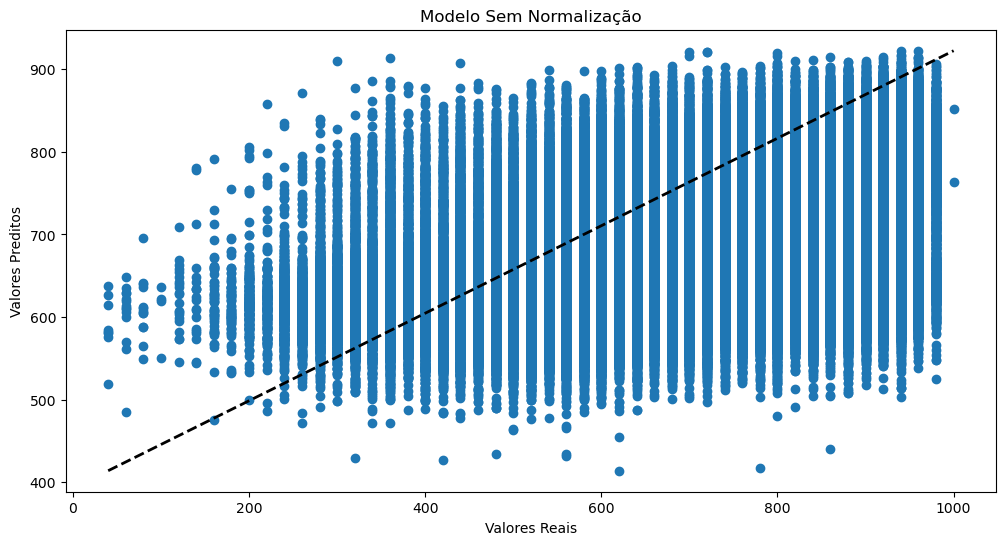

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_predict.min(),y_predict.max()], 'k--', lw=2)
plt.title('Modelo Sem Normalização')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')


#### Nota Média

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features, dados_NotaMediaObjetiva, test_size=0.3, random_state=42)

linearR.fit(X_train, y_train)

y_predict = linearR.predict(X_test)

mean_squared_error(y_test, y_predict)

4203.130940228666

Text(0, 0.5, 'Valores Preditos')

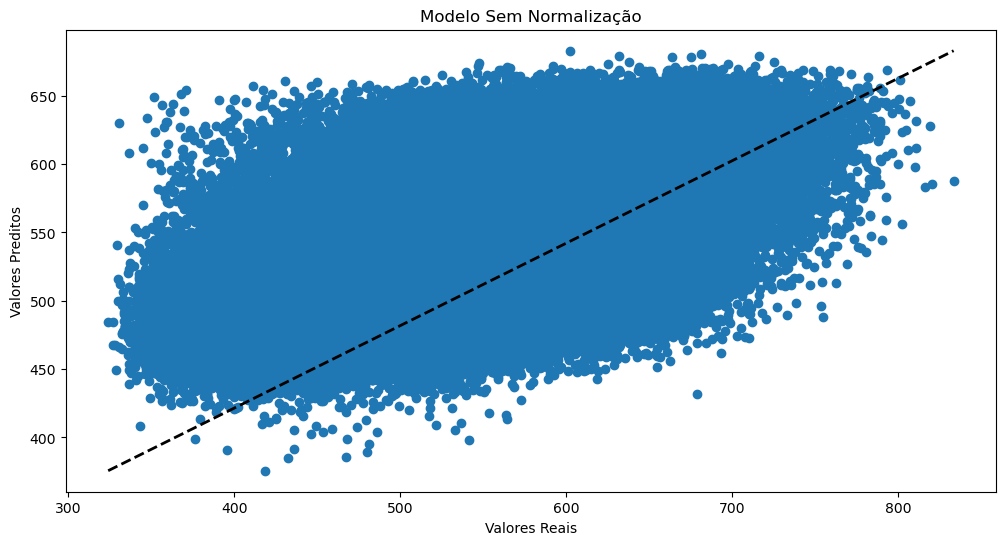

In [25]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_predict.min(),y_predict.max()], 'k--', lw=2)
plt.title('Modelo Sem Normalização')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

#### normalizando dados

In [26]:
from sklearn.preprocessing import StandardScaler # type: ignore
scaler = StandardScaler()

In [34]:
dados_features_esc = scaler.fit_transform(dados_features)

dados_features_esc = pd.DataFrame(dados_features_esc, columns= dados_features.columns)

# dados_features_esc.describe()

In [35]:
# dados_features.columns
dados_features_esc

,Q001,Q002,Q005,Q006,Q007,Q010,Q011,Q012,Q019,Q021,...,SG_UF_ESC_RJ,SG_UF_ESC_RN,SG_UF_ESC_RO,SG_UF_ESC_RR,SG_UF_ESC_RS,SG_UF_ESC_SC,SG_UF_ESC_SE,SG_UF_ESC_SP,SG_UF_ESC_TO,TP_LOCALIZACAO_ESC_2.0
0,-0.491898,-0.700053,0.946867,-0.623116,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
1,-1.598525,-2.006544,0.133586,-0.871451,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
2,-0.491898,-0.046807,0.946867,-0.374781,-0.315631,0.312722,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
3,0.061415,-0.046807,0.133586,-0.871451,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
4,-1.045211,-1.353299,-1.492977,-0.374781,-0.315631,-0.999290,-0.540492,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,-0.217686,-0.185369,-0.108735,1.997955,-0.082922,-0.184063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689246,-1.598525,-0.046807,0.133586,-0.623116,-0.315631,0.312722,1.323998,-0.220014,-0.559304,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
689247,0.061415,1.912930,-0.679696,0.618561,-0.315631,1.624734,-0.540492,-0.220014,2.690643,1.558319,...,-0.27288,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
689248,0.061415,0.606439,-0.679696,0.370225,-0.315631,0.312722,-0.540492,-0.220014,2.690643,-0.641717,...,-0.27288,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063
689249,-1.045211,-0.046807,0.133586,1.363567,-0.315631,1.624734,-0.540492,-0.220014,1.607327,1.558319,...,-0.27288,-0.143643,-0.098244,-0.046966,4.593769,-0.185369,-0.108735,-0.500512,-0.082922,-0.184063


##### Media Objetiva

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    dados_features_esc, dados_NotaMediaObjetiva, test_size=0.3, random_state=42, stratify=dados_features_esc["TP_ESCOLA_3"])

linearR.fit(X_train, y_train)

y_predict = linearR.predict(X_test)

mean_squared_error(y_test, y_predict)

4192.102148036217

Text(0, 0.5, 'Valores Preditos')

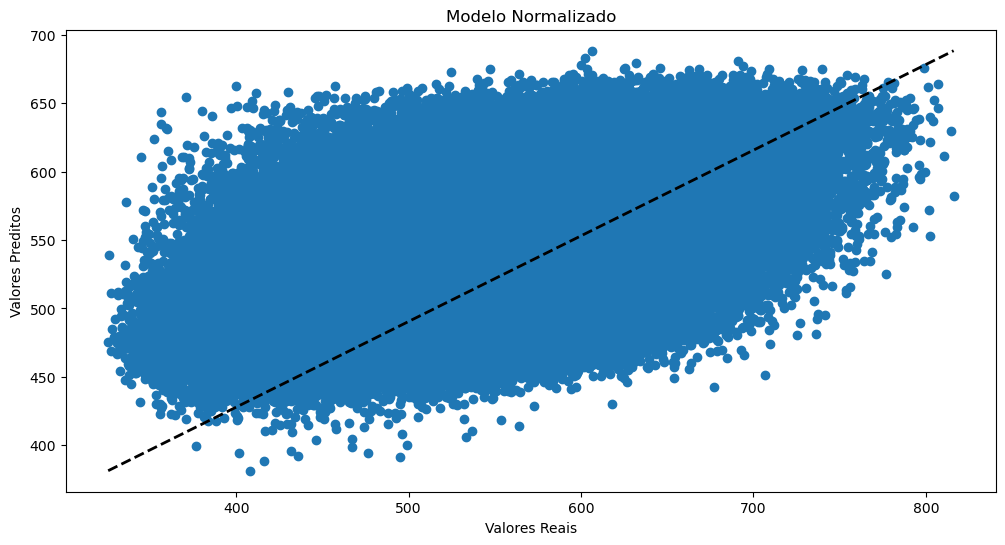

In [39]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_predict.min(),y_predict.max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

##### Redação


In [36]:



X_train, X_test, y_train, y_test = train_test_split(
    dados_features_esc, dados_NotaRedacao, test_size=0.3, random_state=42, stratify=dados_features_esc["TP_ESCOLA_3"])

linearR.fit(X_train, y_train)

y_predict = linearR.predict(X_test)

mean_squared_error(y_test, y_predict)

24990.397667317462

Text(0, 0.5, 'Valores Preditos')

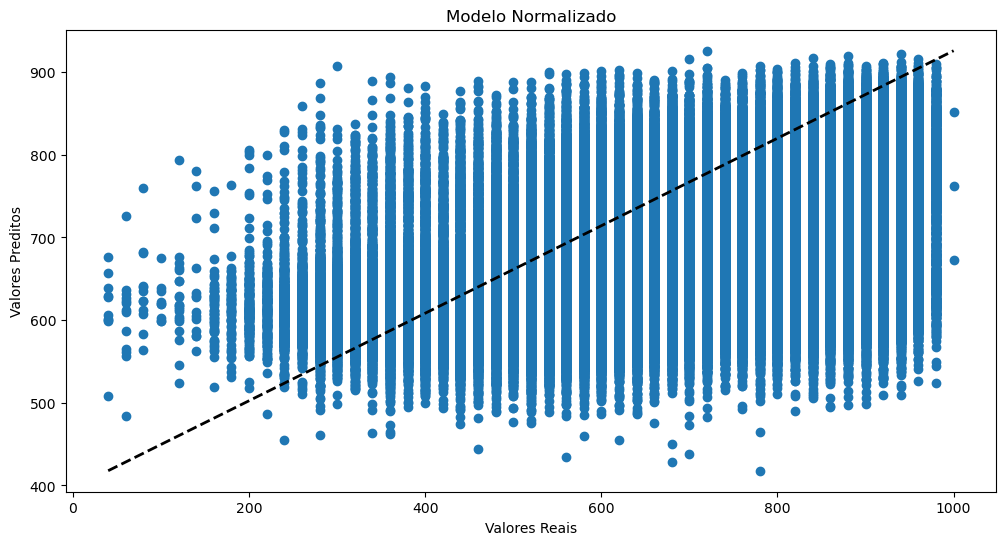

In [37]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_predict.min(),y_predict.max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')

In [51]:
dados_features_esc.shape

(689251, 41)

## RamdomForestRegressor 

In [67]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    dados_features_esc, dados_NotaMediaObjetiva, test_size=0.3, random_state=42, stratify=dados_features_esc["TP_ESCOLA_3"])

regr = RandomForestRegressor(max_depth=12, random_state=17)

regr.fit(X_train, y_train)



RandomForestRegressor(max_depth=12, random_state=17)

In [64]:

y_predict = regr.predict(X_test)

mean_squared_error(y_test, y_predict)

4088.313855704558

In [65]:
mean_squared_error(y_train, regr.predict(X_train))

3645.1867672660724

Text(0, 0.5, 'Valores Preditos')

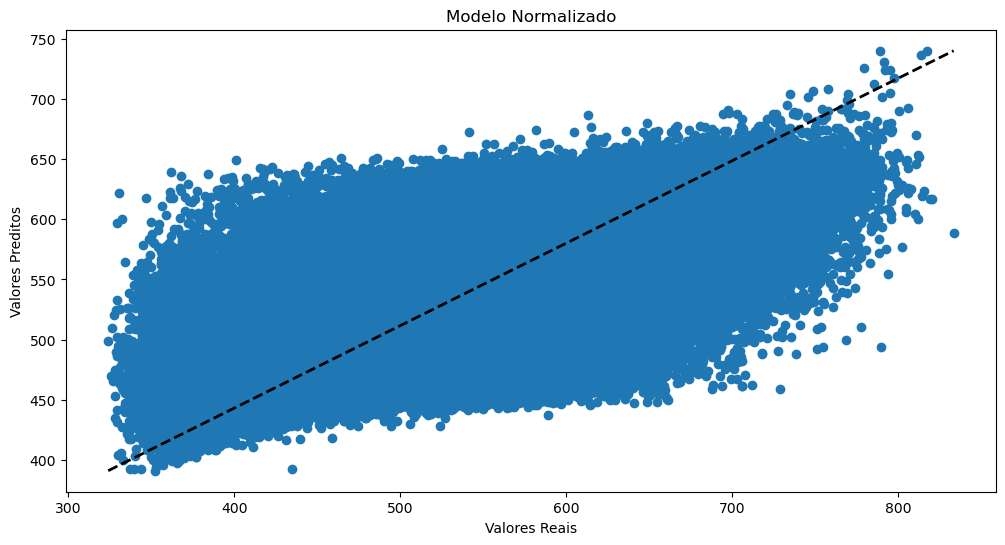

In [66]:
plt.figure(figsize=(12, 6))
plt.scatter(y_train, regr.predict(X_train))
plt.plot([y_train.min(), y_train.max()], [regr.predict(X_train).min(),regr.predict(X_train).max()], 'k--', lw=2)
plt.title('Modelo Normalizado')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')